## Example 5.4 Cylindrical symmetry problem with internal volume constraint

This example shows the solution of an axi-symmetric problem with an internal constraint.
The domain includes a cavity whose volume is kept constant during the simulation but its shape is arbitrary.

In [ ]:
using LinearAlgebra, Statistics
using Printf, WriteVTK, Distributed
using AbaqusReader, PyCall, PyPlot, JLD, MAT

In [ ]:
using AD4SM

a few helper functions to sort the nodes of the internal boundary, calculate the volume of the cavity and quick plotting the solution in the notebook

In [3]:
function sort_bnd(nodes, nid_bnd)
  closest(node0, nodes) = findmin([norm(node0-node) for node in nodes])[2]

  id_srtd   = [nid_bnd[1],]
  lastnode  = nid_bnd[1]
  bnd_nodes = nid_bnd[2:end]

  while !isempty(bnd_nodes)
    idd = closest(nodes[lastnode], nodes[bnd_nodes])
    lastnode = bnd_nodes[idd]
    push!(id_srtd, bnd_nodes[idd])
    deleteat!(bnd_nodes, idd)
  end
  return id_srtd
end

# get_vol(p0) = π/2*sum((p0[2,1:end-1]+p0[2,2:end]) .* 
#                      (p0[1,2:end]-p0[1,1:end-1]) .* 
#                      (p0[1,2:end]+p0[1,1:end-1]) )

get_vol(p0) = π/2*sum(
  (p0[2:2:end-2]+p0[4:2:end]) .* 
  (p0[3:2:end]-p0[1:2:end-2]) .* 
  (p0[3:2:end]+p0[1:2:end-2]) )
#
# functions for plotting
#
function get_I1(elems, u0)
    F   = Elements.getinfo(elems,u0,info=:F)
    [ Materials.getInvariants(transpose(F)*F)[1]-3 for F in F] 
end
patch = pyimport("matplotlib.patches")
coll  = pyimport("matplotlib.collections")  
function plot_model(elems, nodes; 
                    u = zeros(length(nodes[1]), length(nodes)),
                    Φ = [],
                    linewidth = 0.25,
                    facecolor = :c,
                    edgecolor = :b, 
                    alpha     = 1,
                    cmap      = :hsv,
                    clim      = [],
                    dTol      = 1e-6,
                    cfig      = figure(),
                    ax        = cfig.add_subplot(1,1,1))

  nodes     = [node + u[:,ii] for (ii,node) in enumerate(nodes)]
  patchcoll = coll.PatchCollection([patch.Polygon(nodes[elem.nodes]) 
                                    for elem ∈ elems], cmap=cmap)
    if !isempty(Φ)
    patchcoll.set_array(Φ)
    cfig.colorbar.(patchcoll, ax=ax)

    if isempty(clim)
      clim = patchcoll.get_clim()
      if abs(clim[2]-clim[1]) < dTol
        clim  = sum(clim)/2*[0.9, 1.1]
      end
    end
    patchcoll.set_clim(clim)
  else
    patchcoll.set_color(facecolor)
  end

  patchcoll.set_edgecolor(edgecolor)
  patchcoll.set_alpha(alpha)
  patchcoll.set_linewidth(linewidth)

  ax.set_aspect("equal")
  ax.add_collection(patchcoll)
  ax.autoscale()
  (cfig, ax, patchcoll)
end
;

In [58]:
sMeshFile = "AxSymDomainj.inp"
mat       = Materials.NeoHooke(1e1)
Δu        = 18
sPosFix   = "NHd"
Nsteps    = 10
LF        = range(1/100Nsteps,1,length=Nsteps)
dTol      = 1e-6
sVTKpath  = "./vtk_files/"
ballus    = true
;

┌ Info: 916 nodes found
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:109
┌ Info: Parsing elements. Type: CPS4. Topology: Quad4
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:153
┌ Info: Creating nset TOP
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:187
┌ Info: Creating elset TOP
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:187
┌ Info: Creating nset BTM
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:187
┌ Info: Creating elset BTM
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:187
┌ Info: Creating nset BND
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:187
┌ Info: Creating elset BND
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/SDhGN/src/parse_mesh.jl:187
┌ Info: Creating nset ALL
└ @ AbaqusReader /home/andrea/.julia/pack

(nNodes, nElems) = (length(nodes), length(elems)) = (916, 796)


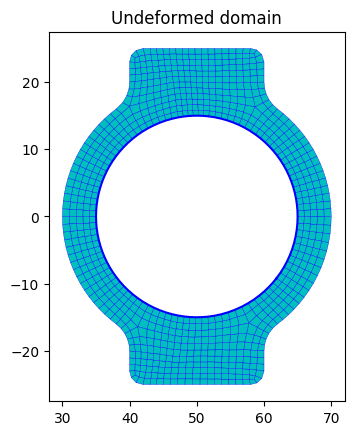

V0 = get_vol(pos0) = 221925.20483454564


In [59]:
sFileName = splitext(basename(sMeshFile))[1];
mymodel   = AbaqusReader.abaqus_read_mesh(sMeshFile)
nodes     = [mymodel["nodes"][ii] for ii in 1:mymodel["nodes"].count]
el_nodes  = [item[2]              for item in mymodel["elements"]] 

# for node in nodes
#   node[1]-=10
# end

id_btm   = mymodel["node_sets"]["BTM"]
id_top   = mymodel["node_sets"]["TOP"]
id_bnd   = mymodel["node_sets"]["BND"]

elems     = []
for item ∈ el_nodes
if length(item)==3
  push!(elems, Elements.ASTria(item, nodes[item], mat=mat))
elseif length(item)==4
  push!(elems, Elements.ASQuad(item, nodes[item], mat=mat))
end
end    

points    = hcat(nodes...)
cells     = [if length(nodes)==3
             MeshCell(VTKCellTypes.VTK_TRIANGLE, nodes)
           else length(nodes)==4
             MeshCell(VTKCellTypes.VTK_QUAD, nodes)
           end  for nodes in el_nodes ]
                
@show (nNodes, nElems) = (length(nodes), length(elems)); flush(stdout)

# sort the internal boundary nodes
#
id_srtd   = sort_bnd(nodes, id_bnd);
push!(id_srtd, id_srtd[1])
pos0      = hcat(nodes[id_srtd]...)
idxu      = LinearIndices((2,nNodes))
@show V0  = get_vol(pos0)

        
plot_model(elems, nodes)
PyPlot.plot(pos0[1,:], pos0[2,:], color=:b)        
PyPlot.title("Undeformed domain")
;

## Compression test

### add volume constraint

In [60]:
nid_bnd = length(id_srtd)
nDoFsu  = 2*nNodes
q       = 10
nGropus = ceil(Int, nid_bnd/q)

id_eqs_DoFs = [(ii-1)*q+1:ii*q+1 for ii in 1:nGropus-1]
append!(id_eqs_DoFs, [id_eqs_DoFs[end][end]:nid_bnd])

EqsV = vcat(
  [begin
      id_bnd_ii = id_srtd[idx]
      idx_ii = idxu[:, id_bnd_ii][:]
      Elements.ConstEq(x->get_vol(pos0[:,idx][:]+x[1:end-1])-x[end], 
                        vcat(idx_ii, nDoFsu+ii), adiff.D2)
      end for (ii,idx) in enumerate(id_eqs_DoFs)] ...,
  Elements.ConstEq(x->sum(x)-V0, nDoFsu+1:nDoFsu+nGropus, adiff.D2))

EqsM = [Elements.ConstEq(x->elem.V*(Elements.getJ(Elements.getF(elem, x))-1), 
                               idxu[:,elem.nodes][:], adiff.D2)
        for elem in elems]


eqns  = vcat(EqsV..., EqsM...)
@show nEqns = length(eqns)
;

nEqns = length(eqns) = 808


In [61]:
# displacement boundary conditions
idxu   = LinearIndices((2,nNodes))
u0     = 1e-4randn(2, nNodes+ceil(Int, nGropus/2))
bifree = trues(size(u0))
λ      = zeros(nEqns)

bifree[idxu[:,id_btm]] .= false
bifree[idxu[2,id_top]] .= false
;

Progress:  Time: 0:00:02 (4 iterations)


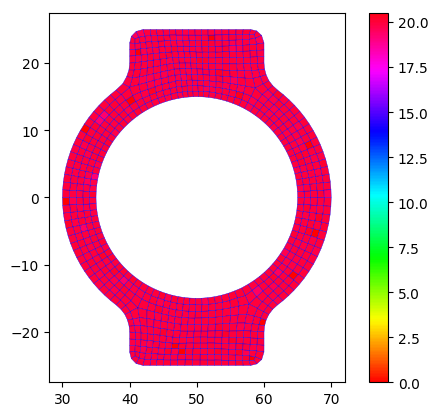

  2.067805 seconds (2.12 M allocations: 3.254 GiB, 18.64% gc time)


In [62]:
@time Elements.solvestep!(elems, 
        u0, bifree, λ=λ, bprogress=true, becho=false, dTol=dTol, eqns=eqns)
plot_model(elems, nodes, u = u0, Φ=λ)
PyPlot.plot(pos0[1,:]+u0[1,id_srtd], pos0[2,:]+u0[2,id_srtd], color=:b) 
;

In [63]:
u           = copy(u0)
u[:,id_btm] .= 0
u[2,id_top] .= -Δu

allus_d = Elements.solve(elems, u, ifree=bifree, λ=λ, eqns=eqns, LF=LF,
                     becho=true, bechoi=false, ballus=ballus, bprogress=false,
                     dTol=dTol, maxiter=21)
;

step  1 done in  3 iter, after 1.63 sec.
step  2 done in  5 iter, after 2.98 sec.
step  3 done in  5 iter, after 2.40 sec.
step  4 done in  5 iter, after 2.50 sec.
step  5 done in  5 iter, after 2.60 sec.
step  6 done in  5 iter, after 2.56 sec.
step  7 done in  5 iter, after 2.32 sec.
step  8 done in  6 iter, after 2.89 sec.
step  9 done in 13 iter, after 6.36 sec.
step 10 done in  6 iter, after 2.82 sec.
completed in 29 seconds


### now remove the volume constraint 

In [64]:
eqns = [Elements.ConstEq(x->elem.V*(Elements.getJ(Elements.getF(elem, x))-1), 
                               idxu[:,elem.nodes][:], adiff.D2)
        for elem in elems]

@show nEqns = length(eqns)
;

nEqns = length(eqns) = 796


In [65]:
# displacement boundary conditions
idxu   = LinearIndices((2,nNodes))
u0     = 1e-4randn(2, nNodes)
bifree = trues(size(u0))
λ      = zeros(nEqns)

bifree[idxu[:,id_btm]] .= false
bifree[idxu[2,id_top]] .= false
;

In [66]:
@time Elements.solvestep!(elems, 
        u0, bifree, λ=λ, bprogress=true, becho=false, maxiter = 21, dTol=dTol, eqns=eqns)
;

Progress:  Time: 0:00:01 (4 iterations)


  1.921883 seconds (2.07 M allocations: 3.187 GiB, 19.74% gc time)


In [67]:
u            = copy(u0)
u[:,id_btm] .= 0
u[2,id_top] .= -Δu

allus_e = Elements.solve(elems, u, ifree=bifree, λ=λ, eqns=eqns, LF=LF,
                     becho=true, bechoi=false, ballus=ballus, bprogress=false,
                     dTol=dTol, maxiter=21)
;

step  1 done in  3 iter, after 1.59 sec.
step  2 done in  5 iter, after 2.49 sec.
step  3 done in  5 iter, after 2.32 sec.
step  4 done in  5 iter, after 2.48 sec.
step  5 done in  4 iter, after 1.86 sec.
step  6 done in  4 iter, after 2.02 sec.
step  7 done in  4 iter, after 1.80 sec.
step  8 done in  4 iter, after 1.81 sec.
step  9 done in  4 iter, after 1.80 sec.
step 10 done in  4 iter, after 1.82 sec.
completed in 19 seconds


Plot some of the results

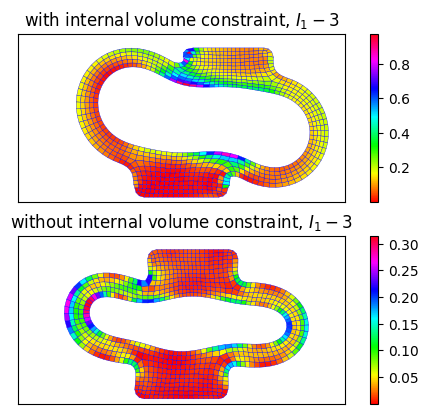

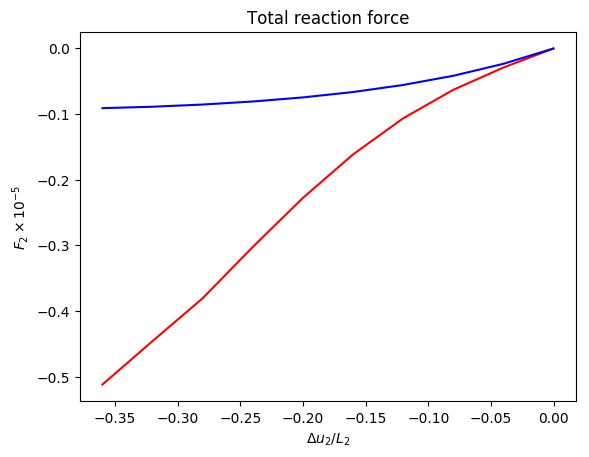

In [68]:
cfig = PyPlot.figure()

ax1  = cfig.add_subplot(2,1,1)
plot_model(elems, nodes, cfig=cfig, ax=ax1, 
    u=allus_d[end][1], Φ=get_I1(elems, allus_d[end][1]))
PyPlot.plot(pos0[1,:]+allus_d[end][1][1,id_srtd],
  pos0[2,:]+allus_d[end][1][2,id_srtd], color=:b)        

ax2  = cfig.add_subplot(2,1,2)
plot_model(elems, nodes, cfig=cfig, ax=ax2, 
    u=allus_e[end][1], Φ=get_I1(elems, allus_e[end][1]))
PyPlot.plot(pos0[1,:]+allus_e[end][1][1,id_srtd],
  pos0[2,:]+allus_e[end][1][2,id_srtd], color=:b)        

ax1.set_xlim([15, 85]); ax1.set_ylim([-26, 10])
ax1.set_title("with internal volume constraint, \$I_1-3\$")
ax1.set_xticks([]); ax1.set_yticks([])
ax2.set_xlim([15, 85]); ax2.set_ylim([-26, 10])
ax2.set_title("without internal volume constraint, \$I_1-3\$")
ax2.set_xticks([]); ax2.set_yticks([])

rf_tot_d = [sum(item[2][2, id_top])  for item in allus_d]
Δu_tot_d = [mean(item[1][2,id_top])  for item in allus_d]

rf_tot_e = [sum(item[2][2, id_top])  for item in allus_e]
Δu_tot_e = [mean(item[1][2,id_top])  for item in allus_e]

PyPlot.figure()
PyPlot.plot(Δu_tot_d/50, rf_tot_d/1e5, color=:r)
PyPlot.plot(Δu_tot_e/50, rf_tot_e/1e5, color=:b)
PyPlot.xlabel("\$\\Delta u_2/L_2\$")
PyPlot.ylabel("\$F_2\\times10^{-5}\$")
PyPlot.title("Total reaction force")
;